In [ ]:
# Imports and DB setup
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Connect to an in-memory SQLite DB (or file: olap.db)
conn = sqlite3.connect('olap.db')

In [ ]:
# Create tables
cur = conn.cursor()
cur.executescript('''
DROP TABLE IF EXISTS sales;
DROP TABLE IF EXISTS products;
DROP TABLE IF EXISTS dates;


CREATE TABLE products (
product_id INTEGER PRIMARY KEY,
category TEXT,
name TEXT,
price REAL
);


CREATE TABLE dates (
date TEXT PRIMARY KEY,
year INTEGER,
quarter INTEGER,
month INTEGER
);


CREATE TABLE sales (
sale_id INTEGER PRIMARY KEY,
date TEXT,
product_id INTEGER,
quantity INTEGER,
revenue REAL,
FOREIGN KEY(product_id) REFERENCES products(product_id),
FOREIGN KEY(date) REFERENCES dates(date)
);
''')
conn.commit()

In [ ]:
# Insert sample dimension data (extend as needed)
products = [
(1, 'Electronics', 'Smartphone A', 300),
(2, 'Electronics', 'Headphones B', 50),
(3, 'Home', 'Blender C', 80),
(4, 'Clothing', 'T-Shirt D', 20)
]


dates = [
('2024-01-15', 2024, 1, 1),
('2024-02-20', 2024, 1, 2),
('2024-03-05', 2024, 1, 3),
('2024-04-10', 2024, 2, 4),
('2025-01-12', 2025, 1, 1)
]


sales = [
(1, '2024-01-15', 1, 2, 600),
(2, '2024-01-15', 2, 5, 250),
(3, '2024-02-20', 3, 1, 80),
(4, '2024-03-05', 1, 1, 300),
(5, '2024-04-10', 4, 10, 200),
(6, '2025-01-12', 1, 3, 900)
]


cur.executemany('INSERT INTO products VALUES (?,?,?,?)', products)
cur.executemany('INSERT INTO dates VALUES (?,?,?,?)', dates)
cur.executemany('INSERT INTO sales VALUES (?,?,?,?,?)', sales)
conn.commit()

In [ ]:
# ROLAP queries 
q1 = '''SELECT p.category, AVG(s.revenue) AS avg_revenue
FROM sales s JOIN products p ON s.product_id = p.product_id
GROUP BY p.category
ORDER BY avg_revenue DESC;'''


q2 = '''SELECT d.year, SUM(s.revenue) AS total_revenue
FROM sales s JOIN dates d ON s.date = d.date
GROUP BY d.year
ORDER BY d.year;'''


q3 = '''SELECT p.category, p.name, SUM(s.quantity) AS sold_qty
FROM sales s JOIN products p ON s.product_id = p.product_id
GROUP BY p.category, p.name
ORDER BY p.category, sold_qty DESC;'''


for q in (q1, q2, q3):
    df = pd.read_sql_query(q, conn)
display(df)

,category,name,sold_qty
0,Clothing,T-Shirt D,10
1,Electronics,Smartphone A,6
2,Electronics,Headphones B,5
3,Home,Blender C,1


In [ ]:
# Loading full sales to join into pandas
df_sales = pd.read_sql_query('''
SELECT s.sale_id, s.date, d.year, d.quarter, d.month, p.product_id, p.category, p.name, s.quantity, s.revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date
''', conn)


# Pivot table: revenue by category x year
cube = pd.pivot_table(df_sales, values='revenue', index='category', columns='year', aggfunc='sum', fill_value=0)
cube

year,2024,2025
category,,
Clothing,200.0,0.0
Electronics,1150.0,900.0
Home,80.0,0.0


In [ ]:
#  HOLAP 
# Using SQL for detailed rows (ROLAP)
details = pd.read_sql_query('SELECT * FROM sales', conn)


# Use pandas to create summaries (MOLAP)
summary = df_sales.groupby(['category','year']).agg(total_revenue=('revenue','sum'), total_qty=('quantity','sum')).reset_index()
summary_pivot = summary.pivot(index='category', columns='year', values='total_revenue').fillna(0)


display(details.head())
summary_pivot

,sale_id,date,product_id,quantity,revenue
0,1,2024-01-15,1,2,600.0
1,2,2024-01-15,2,5,250.0
2,3,2024-02-20,3,1,80.0
3,4,2024-03-05,1,1,300.0
4,5,2024-04-10,4,10,200.0


year,2024,2025
category,,
Clothing,200.0,0.0
Electronics,1150.0,900.0
Home,80.0,0.0


In [8]:
# Slice: sales in 2024
slice_2024 = df_sales[df_sales['year'] == 2024]


# Dice: Q1 2024 and Electronics only
dice = df_sales[(df_sales['year'] == 2024) & (df_sales['quarter'] == 1) & (df_sales['category'] == 'Electronics')]


# Roll-Up: aggregate product -> category -> year
rollup = df_sales.groupby(['category','year']).agg(total_revenue=('revenue','sum')).reset_index()


# Drill-Down: year -> quarter -> month (example for 2024)
drill = df_sales[df_sales['year']==2024].groupby(['quarter','month']).agg(total_revenue=('revenue','sum')).reset_index()


display(slice_2024)
display(dice)
display(rollup)
display(drill)

,sale_id,date,year,quarter,month,product_id,category,name,quantity,revenue
0,1,2024-01-15,2024,1,1,1,Electronics,Smartphone A,2,600.0
1,2,2024-01-15,2024,1,1,2,Electronics,Headphones B,5,250.0
2,3,2024-02-20,2024,1,2,3,Home,Blender C,1,80.0
3,4,2024-03-05,2024,1,3,1,Electronics,Smartphone A,1,300.0
4,5,2024-04-10,2024,2,4,4,Clothing,T-Shirt D,10,200.0


,sale_id,date,year,quarter,month,product_id,category,name,quantity,revenue
0,1,2024-01-15,2024,1,1,1,Electronics,Smartphone A,2,600.0
1,2,2024-01-15,2024,1,1,2,Electronics,Headphones B,5,250.0
3,4,2024-03-05,2024,1,3,1,Electronics,Smartphone A,1,300.0


,category,year,total_revenue
0,Clothing,2024,200.0
1,Electronics,2024,1150.0
2,Electronics,2025,900.0
3,Home,2024,80.0


,quarter,month,total_revenue
0,1,1,850.0
1,1,2,80.0
2,1,3,300.0
3,2,4,200.0


<Figure size 640x480 with 0 Axes>

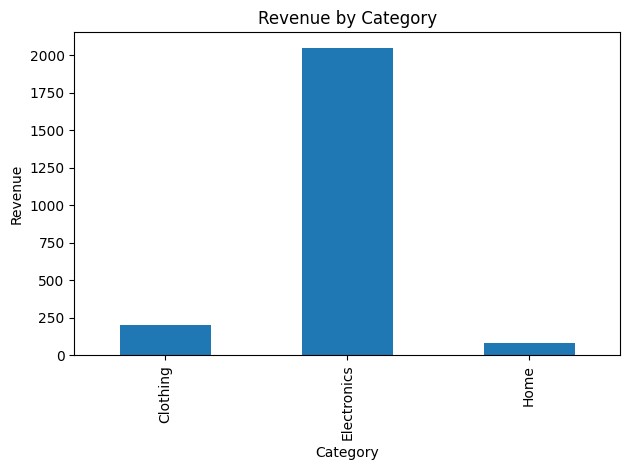

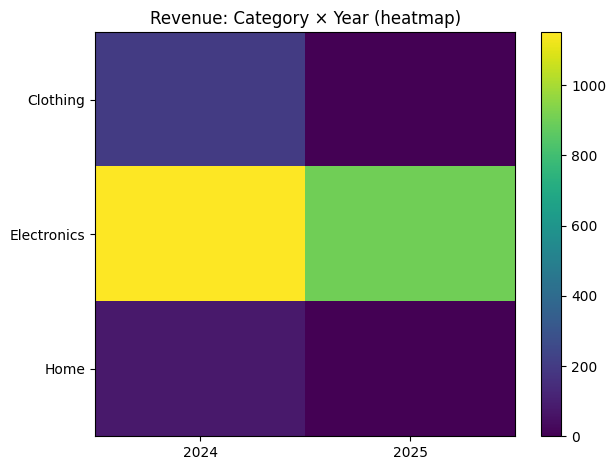

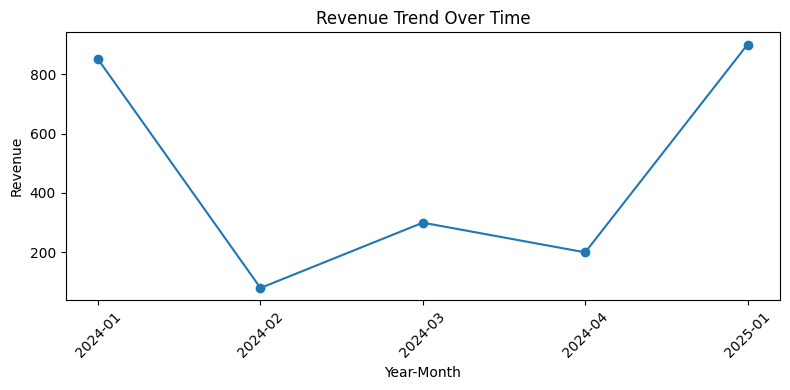

In [ ]:
# Plot revenue by category (bar)
agg = df_sales.groupby('category').revenue.sum().reset_index()
plt.figure()
agg.plot(kind='bar', x='category', y='revenue', legend=False)
plt.title('Revenue by Category')
plt.xlabel('Category')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()


# Heatmap-like visualization (category x year)
plt.figure()
plt.imshow(cube, aspect='auto')
plt.yticks(range(len(cube.index)), cube.index)
plt.xticks(range(len(cube.columns)), cube.columns)
plt.title('Revenue: Category × Year (heatmap)')
plt.colorbar()
plt.tight_layout()
plt.show()


# Line chart — Revenue trend over time (Year-Month)

# Create a Year-Month column
df_sales['year_month'] = df_sales['year'].astype(str) + "-" + df_sales['month'].astype(str).str.zfill(2)

# Aggregate revenue by Year-Month
trend = df_sales.groupby('year_month').revenue.sum().reset_index()

# Plot
plt.figure(figsize=(8,4))
plt.plot(trend['year_month'], trend['revenue'], marker='o')
plt.title('Revenue Trend Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
